# MAP parameter estimation for a CD-LGSSM using SGD




## Setup

In [1]:
import sys
from jax import numpy as jnp
import jax.random as jr
from matplotlib import pyplot as plt

sys.path.append("../../..")
sys.path.append("../..")

# Our codebase
from continuous_discrete_linear_gaussian_ssm import ContDiscreteLinearGaussianSSM as MySSM

# from dynamax.linear_gaussian_ssm import LinearGaussianConjugateSSM as MySSM
from dynamax.utils.utils import monotonically_increasing

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/iurteaga/miniconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


## Data



Sampling from transition distribution (this may be a poor approximation if you're simulating from a non-linear SDE). It is a highly appropriate choice for linear SDEs.


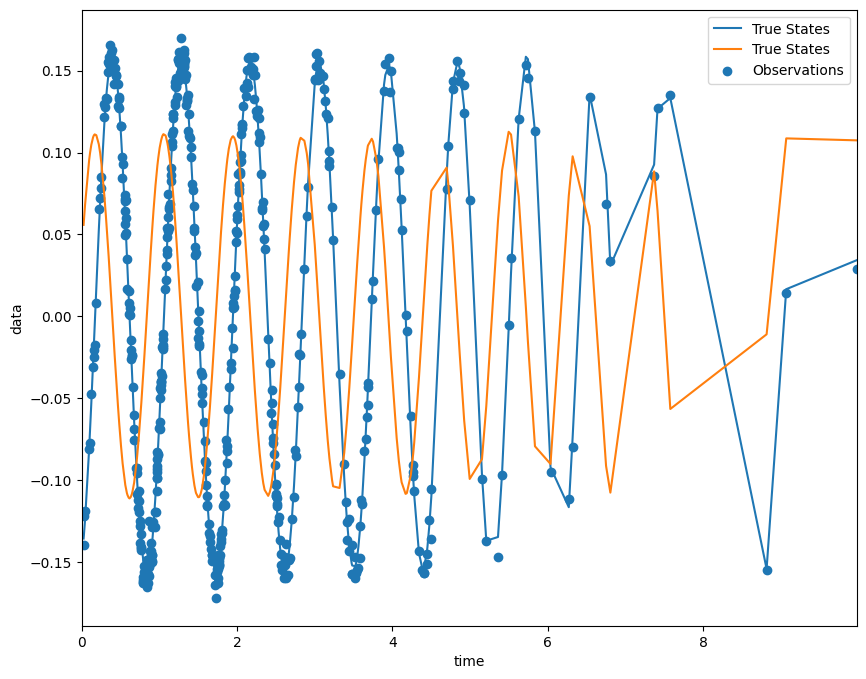

In [2]:
state_dim=2
emission_dim=1
num_timesteps=500
key = jr.PRNGKey(0)

# Parameter definition
initial_mean = jnp.array([0.0, 0.0])
initial_covariance = jnp.eye(state_dim) * 0.1
dynamics_weights  = jnp.array([[0.0, 10.0],
                               [-5.0, 0.0]])
dynamics_diffusion_covariance = jnp.eye(state_dim) * 0.0001
# Only observe first state
emission_weights = jnp.array([[1.0, 0]])
emission_covariance = jnp.eye(emission_dim) * 0.00005

# Model definition: MySSM is a CD-LGSSM
true_model = MySSM(state_dim, emission_dim)
key, key_root = jr.split(key)
true_params, param_props = true_model.initialize(key,
                                        initial_mean=initial_mean,
                                        initial_cov=initial_covariance,
                                        dynamics_weights=dynamics_weights,
                                        dynamics_diffusion_cov=dynamics_diffusion_covariance,
                                        emission_weights=emission_weights,
                                        emission_cov=emission_covariance
                                    )

# irregular sampling schedule
def generate_sorted_gamma_array(N, shape_param, scale_param, rng_key):
    # Generate random values from a gamma distribution.
    gamma_values = jr.gamma(rng_key, shape_param, shape=(N,)) * scale_param
    # Sort the array.
    sorted_values = jnp.sort(gamma_values)
    return sorted_values

shape_param = 2.0  # Shape parameter of the gamma distribution
scale_param = 1.0  # Scale parameter of the gamma distribution
rng_key = jr.PRNGKey(0)  # Initialize a random key
t_emissions = generate_sorted_gamma_array(num_timesteps, shape_param, scale_param, rng_key)
# print(t_emissions)
t_emissions = t_emissions[:,None]

# Data generation from true model, at specified sampling times
key, key_root = jr.split(key)
true_states, emissions = true_model.sample(true_params, key,
                                            num_timesteps=num_timesteps,
                                            t_emissions=t_emissions
                                          )

# Plot the true states and emissions
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t_emissions, true_states, label='True States')
ax.scatter(t_emissions, emissions, label='Observations')
ax.set_ylabel("data")
ax.set_xlabel("time")
ax.set_xlim(0, t_emissions[-1])
ax.legend()

## Plot results

In [3]:
def plot_learning_curve(marginal_lls, true_model, true_params, test_model, test_params, emissions, t_emissions, filter_hyperparams):
    plt.figure()
    plt.xlabel("iteration")
    nsteps = len(marginal_lls)
    plt.plot(marginal_lls, label="estimated")
    true_logjoint = (true_model.log_prior(true_params) + true_model.marginal_log_prob(true_params, filter_hyperparams, emissions, t_emissions))
    plt.axhline(true_logjoint, color = 'k', linestyle = ':', label="true")
    plt.ylabel("marginal joint probability")

    # Adjust y-axis limits
    y_min = min(min(marginal_lls), true_logjoint) * 1.1  # 10% lower than the smallest value
    y_max = max(max(marginal_lls), true_logjoint) * 1.1  # 10% higher than the largest value
    plt.ylim([y_min, y_max])

    plt.yscale('symlog')

    plt.legend()

In [4]:
def plot_scalar(true_val, test_val, title):
    plt.figure()
    plt.bar(["True", "Test"], [true_val, test_val])
    plt.title(title)
    plt.ylabel("Value")
    plt.show()

def plot_vector(true_val, test_val, title):
    x = jnp.arange(len(true_val))
    width = 0.35

    plt.figure()
    plt.bar(x - width/2, true_val, width, label='True')
    plt.bar(x + width/2, test_val, width, label='Test')
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

def plot_matrix(matrix, title):
    plt.figure()
    plt.imshow(matrix, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()

def compare_parameters(true_params, test_params):
    for level_key, inner_tuple in true_params._asdict().items():
        for param_key, true_value in inner_tuple._asdict().items():
            test_value = getattr(getattr(test_params, level_key), param_key)

            title = f"{level_key} - {param_key}"
            if jnp.isscalar(true_value):
                plot_scalar(true_value, test_value, title)
            elif true_value.ndim == 1:
                plot_vector(true_value, test_value, title)
            elif true_value.ndim == 2:
                plot_matrix(true_value, title + " (True Matrix)")
                plot_matrix(test_value, title + " (Test Matrix)")

                # Vectorize matrices and plot
                true_vectorized = true_value.flatten()
                test_vectorized = test_value.flatten()
                plot_vector(true_vectorized, test_vectorized, title + " (Vectorized)")    

In [5]:
def plot_predictions(true_model, true_params, test_model, test_params, emissions, t_emissions):
    # run the smoother w/ test_params on emissions data
    smoothed_emissions, smoothed_emissions_std = test_model.posterior_predictive(test_params, emissions, t_emissions)

    t_emissions = t_emissions.squeeze()
    spc = 3
    plt.figure(figsize=(10, 4))
    for i in range(emission_dim):
        plt.plot(t_emissions, emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
        ln = plt.plot(t_emissions, smoothed_emissions[:, i] + spc * i,
                        label="smoothed" if i == 0 else None)[0]
        plt.fill_between(
            t_emissions,
            spc * i + smoothed_emissions[:, i] - 2 * smoothed_emissions_std[i],
            spc * i + smoothed_emissions[:, i] + 2 * smoothed_emissions_std[i],
            color=ln.get_color(),
            alpha=0.25,
        )
    plt.xlabel("time")
    plt.xlim(0, t_emissions[-1])
    plt.ylabel("true and predicted emissions")
    plt.legend()
    plt.show()

Running KF smoother type = cd_smoother_1
Running KF smoother type 1


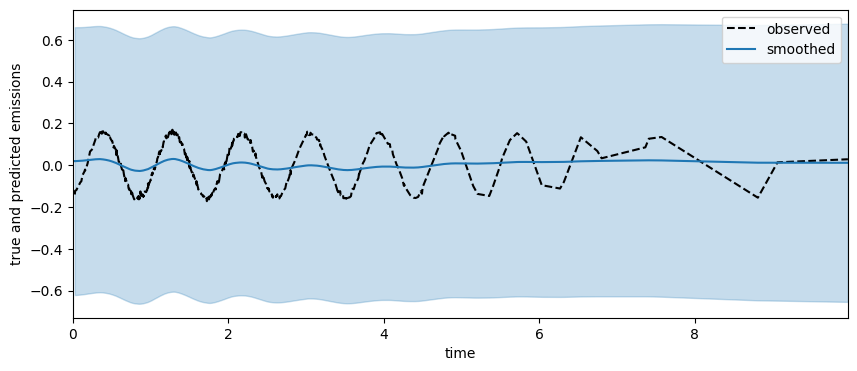

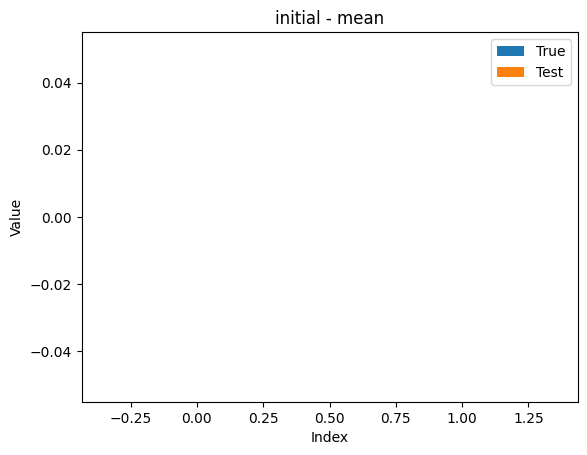

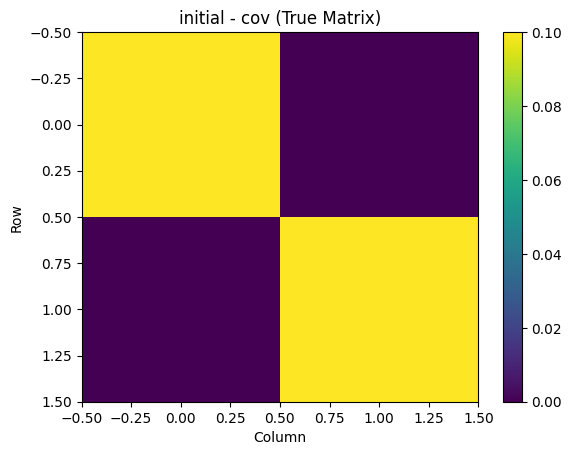

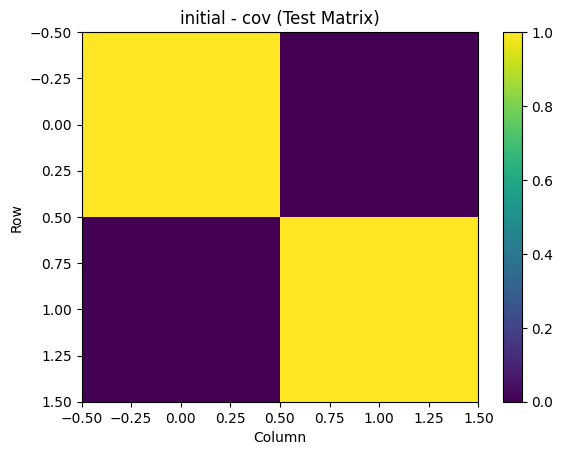

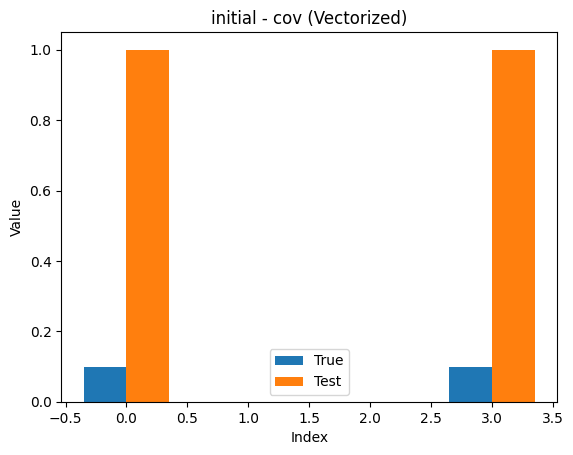

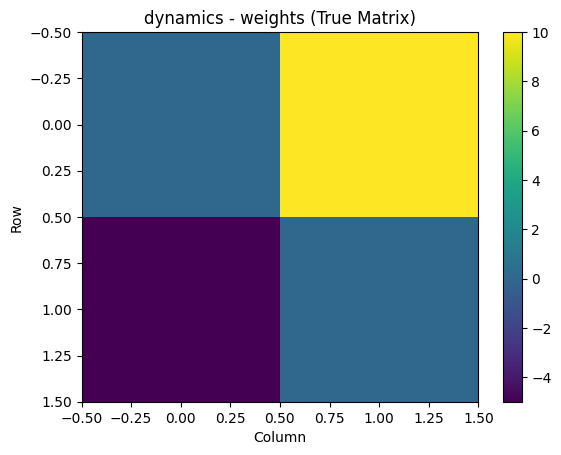

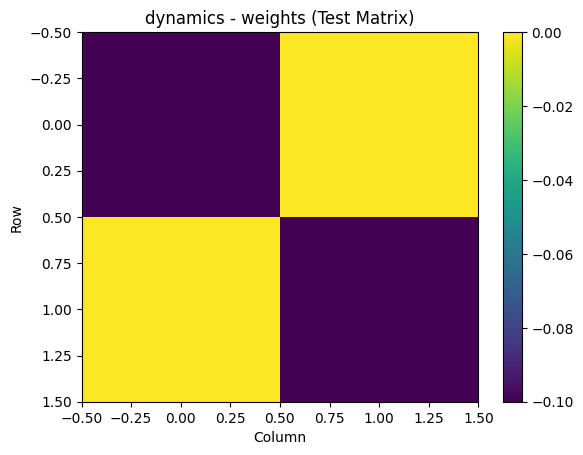

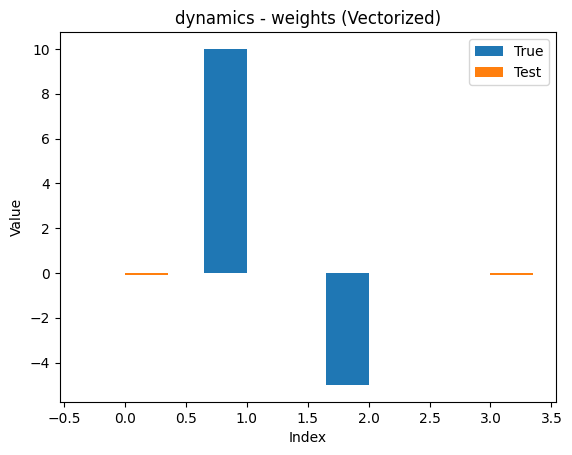

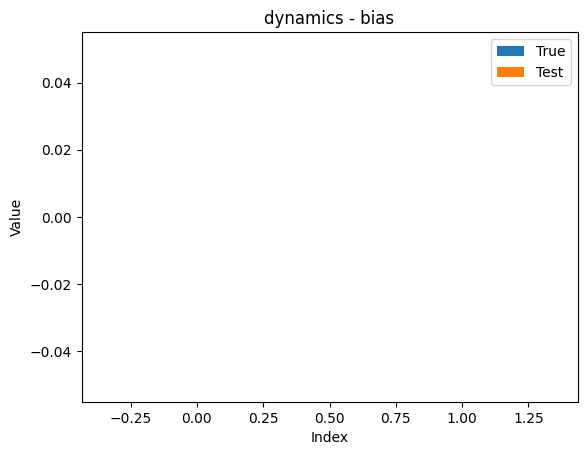

/tmp/ipykernel_34441/951752220.py:23: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(matrix, cmap='viridis', aspect='auto')


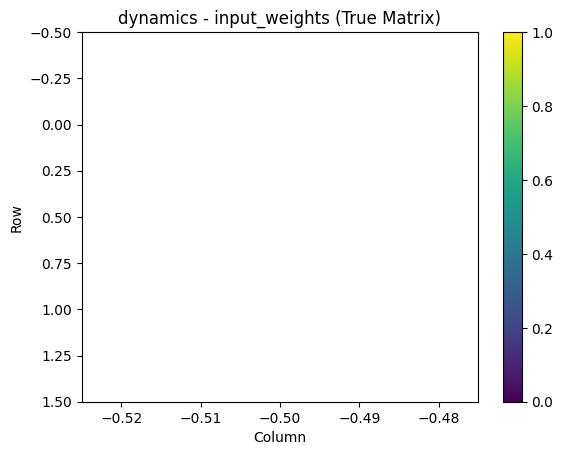

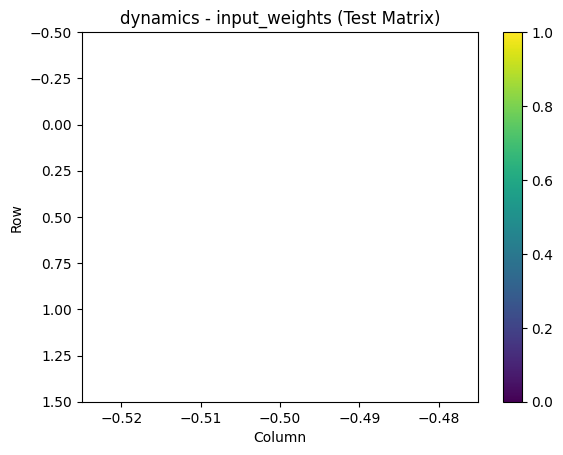

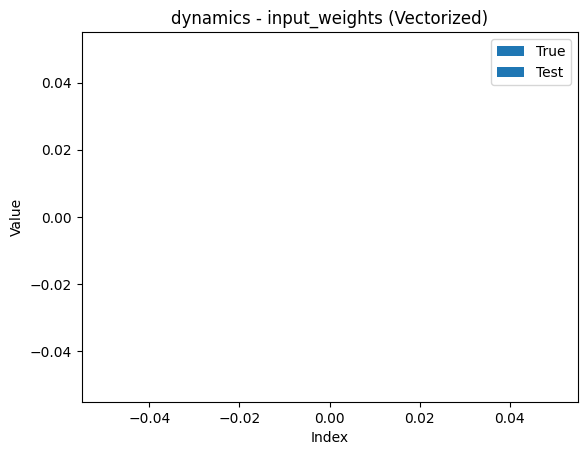

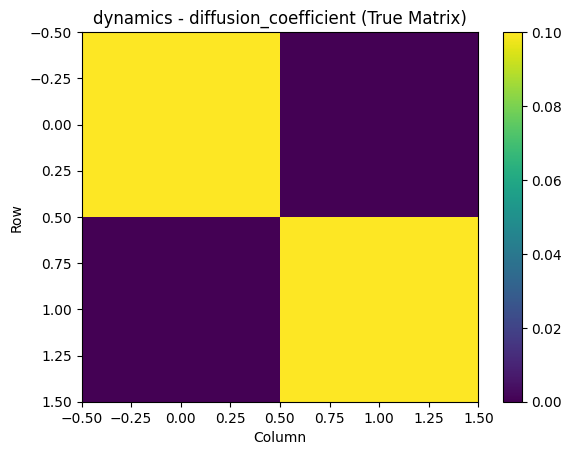

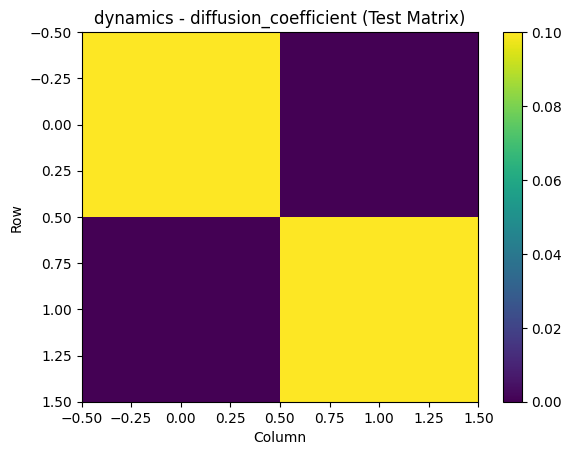

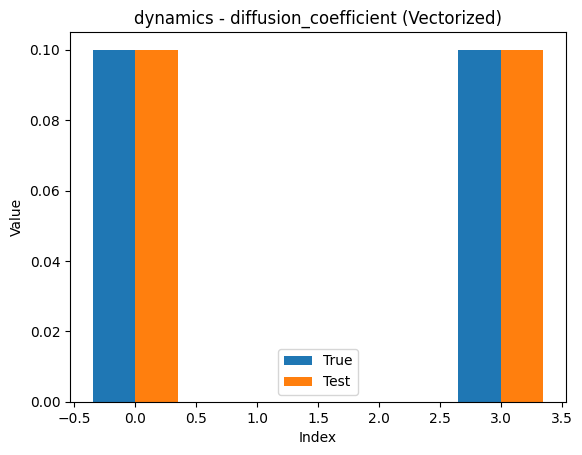

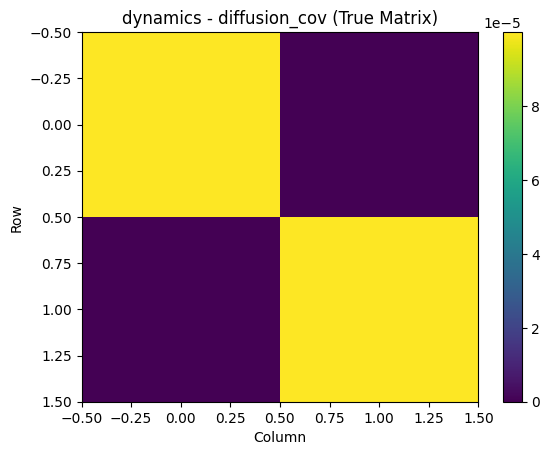

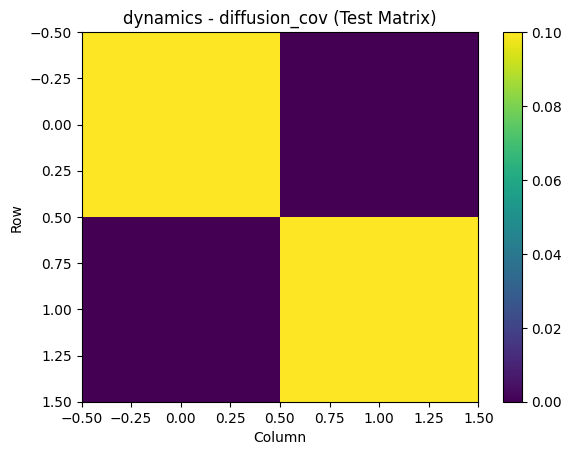

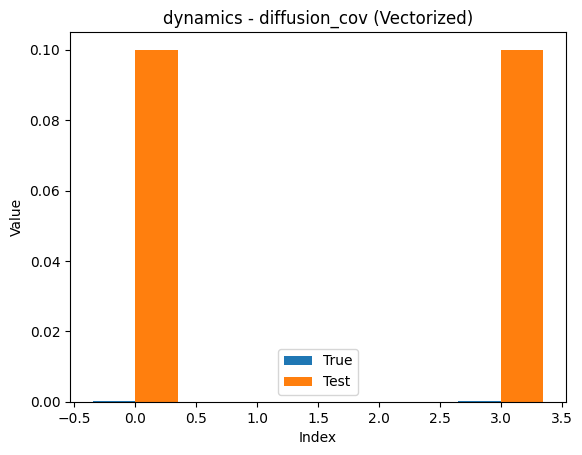

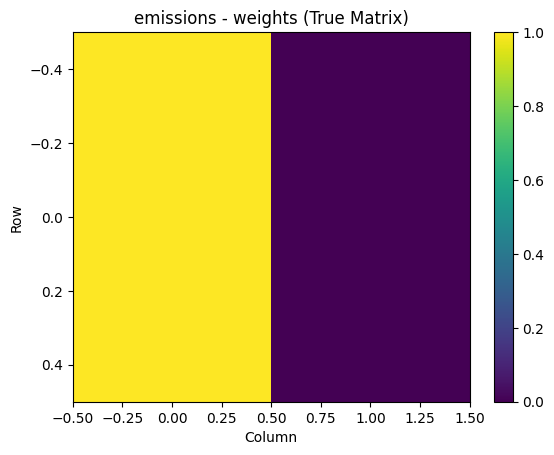

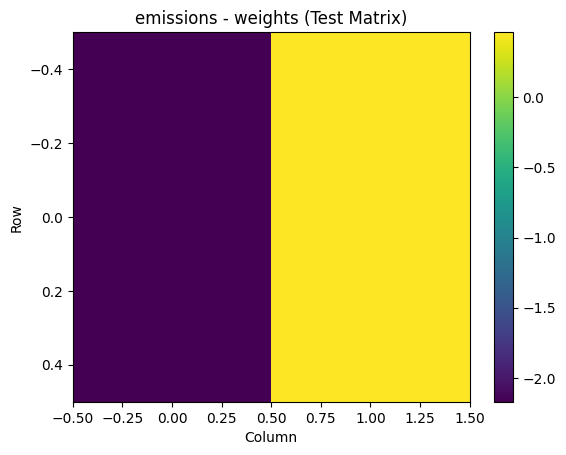

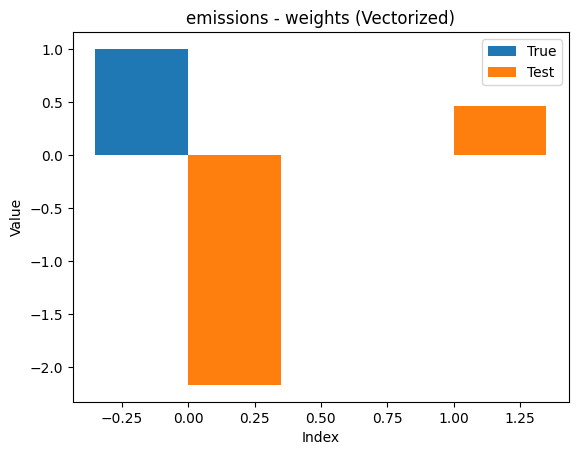

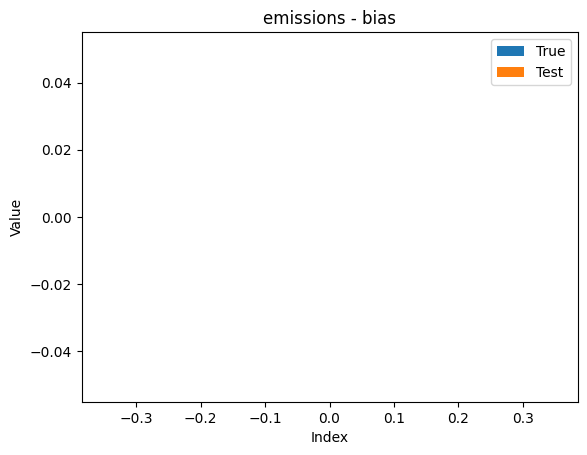

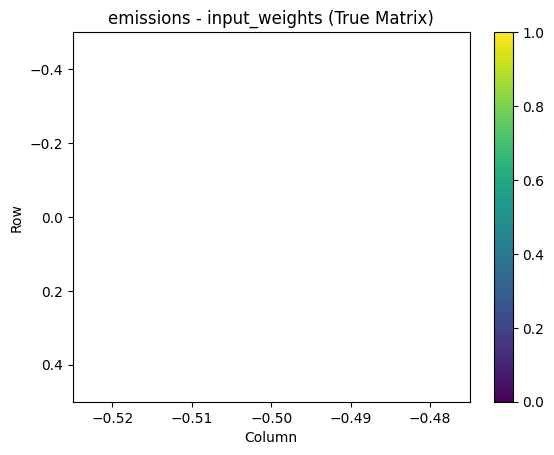

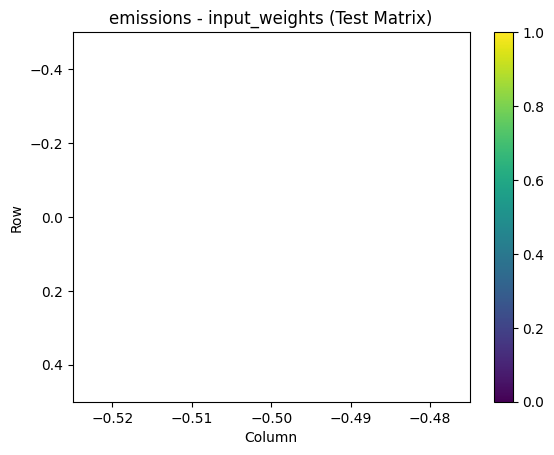

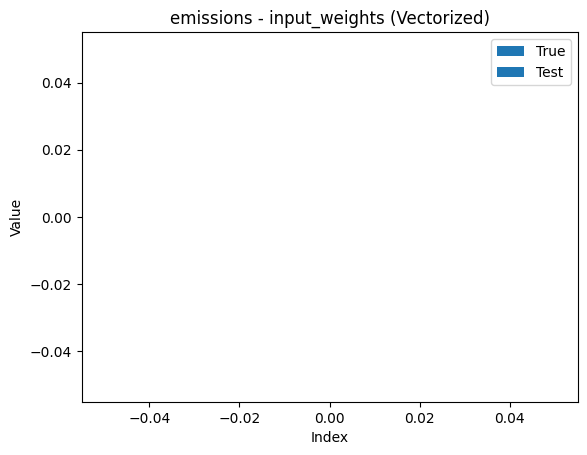

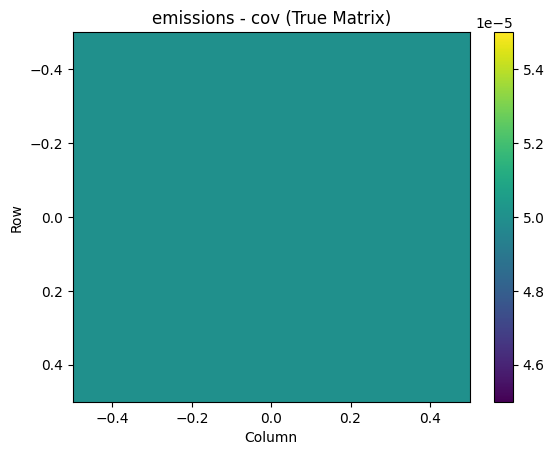

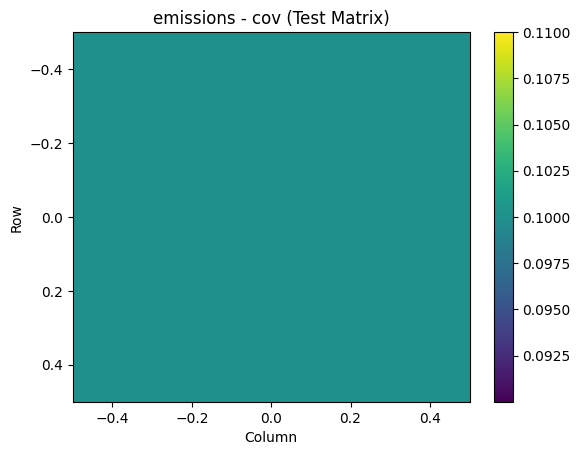

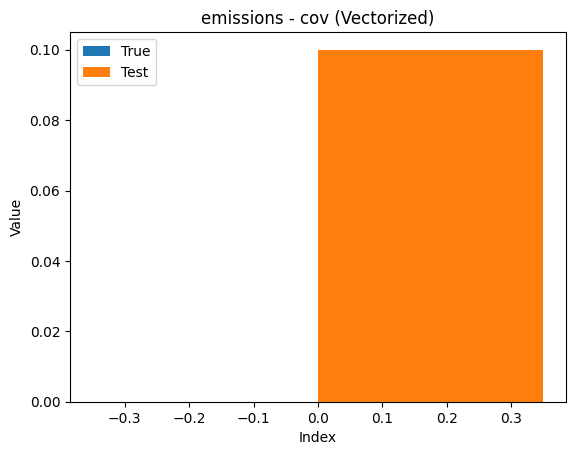

In [6]:
# Plot predictions from a random, untrained model
test_model = MySSM(state_dim, emission_dim)
key = jr.PRNGKey(42)
test_params, param_props = test_model.initialize(key)

plot_predictions(true_model, true_params, test_model, test_params, emissions, t_emissions)
compare_parameters(true_params, test_params)

## Fit with SGD

In [7]:
# Helper functions, SGD schedulers
import optax
def create_exponential_decay_schedule(initial_learning_rate, decay_steps, decay_rate):
    # Exponential decay function
    schedule = optax.exponential_decay(
        init_value=initial_learning_rate,  # Initial learning rate
        transition_steps=decay_steps,      # Steps after which to apply decay
        decay_rate=decay_rate              # Decay rate
    )
    return schedule

def create_adam_optimizer_with_schedule(initial_learning_rate, decay_steps, decay_rate):
    # Create the learning rate schedule
    lr_schedule = create_exponential_decay_schedule(initial_learning_rate, decay_steps, decay_rate)

    # Create the Adam optimizer with the learning rate schedule
    optimizer = optax.chain(
        optax.scale_by_adam(),  # Adam updates
        optax.scale_by_schedule(lr_schedule),  # Scale updates according to the schedule
        optax.scale(-1.0)  # Apply the negative sign for gradient descent
    )
    return optimizer


In [8]:
# Set-up SGD optimizer: ADAM with lr schedule
initial_learning_rate = 2e-2
decay_steps = 200
decay_rate = 0.5
optimizer = create_adam_optimizer_with_schedule(initial_learning_rate, decay_steps, decay_rate)

In [9]:
test_model = MySSM(state_dim, emission_dim)
key = jr.PRNGKey(42)
num_epochs = 1000
# optimizer = optax.adam(0.5e-2) # default of 1e-3 LR is a bit slow
test_params, param_props = test_model.initialize(key)

In [10]:
# Set up Filter: WHY is this nonlinear and uses EKF???
from continuous_discrete_nonlinear_gaussian_ssm import EKFHyperParams
filter_hyperparams = EKFHyperParams()

# Fit model with EKF?
test_params, neg_marginal_lls = test_model.fit_sgd(
    test_params,
    param_props,
    emissions,
    filter_hyperparams,
    t_emissions,
    optimizer=optimizer,
    num_epochs=num_epochs
)
marginal_lls = -neg_marginal_lls * emissions.size

Running KF smoother type = cd_smoother_1
Running KF smoother type 1


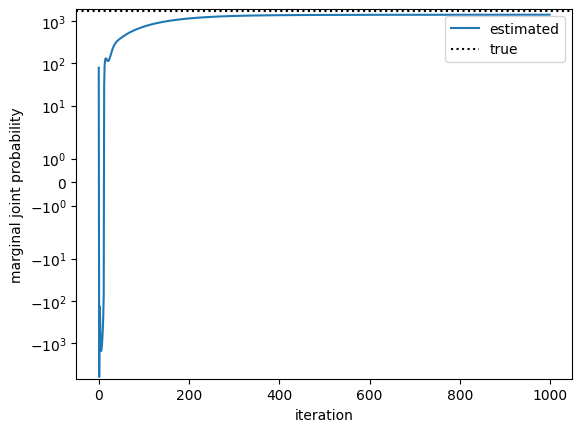

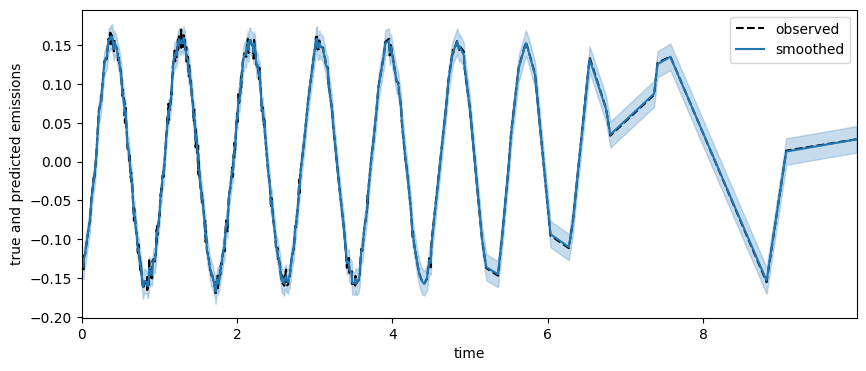

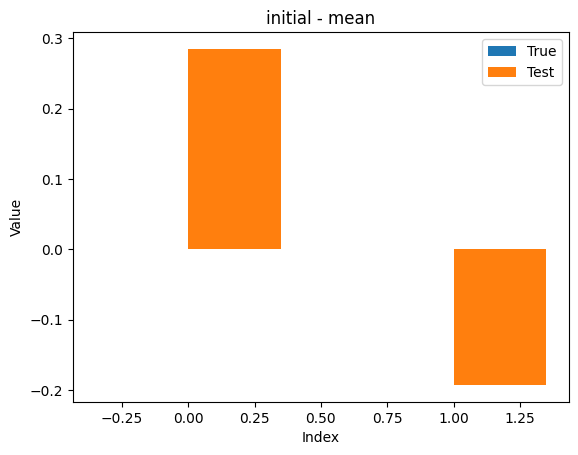

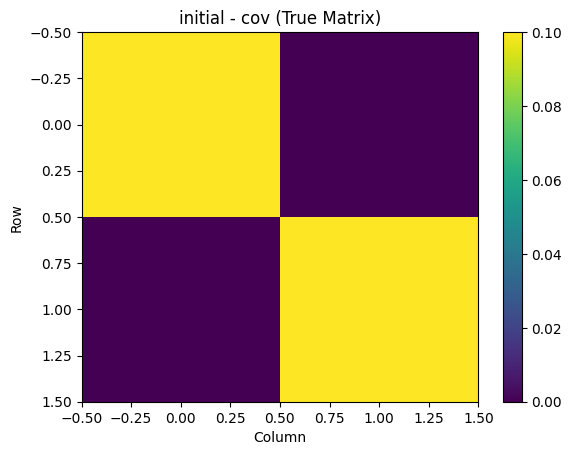

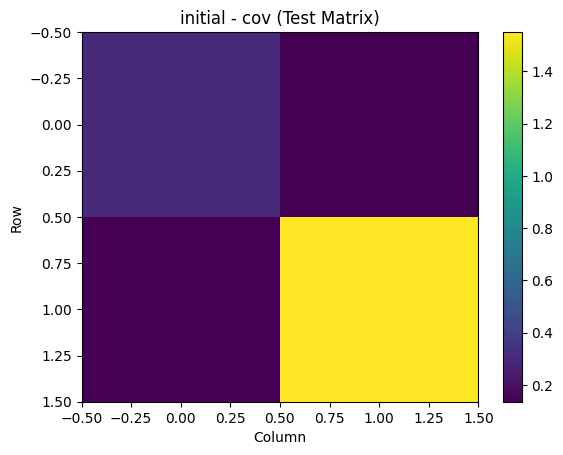

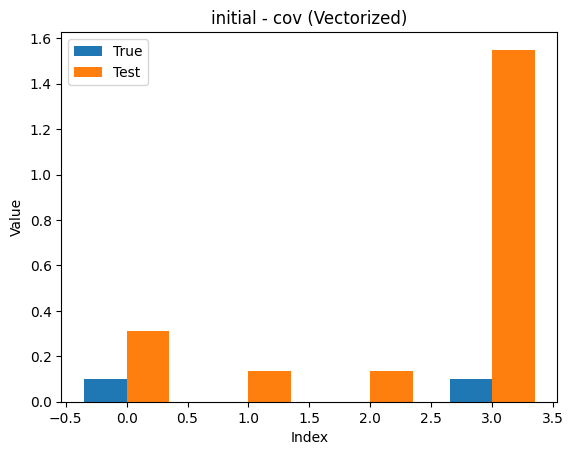

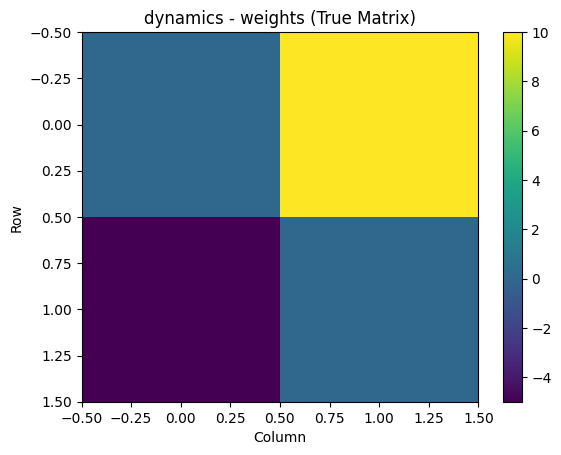

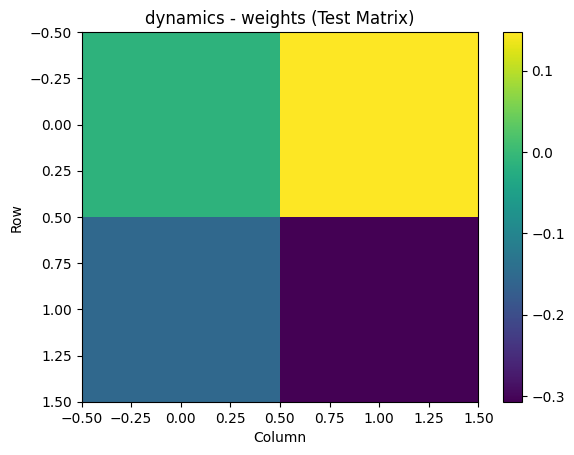

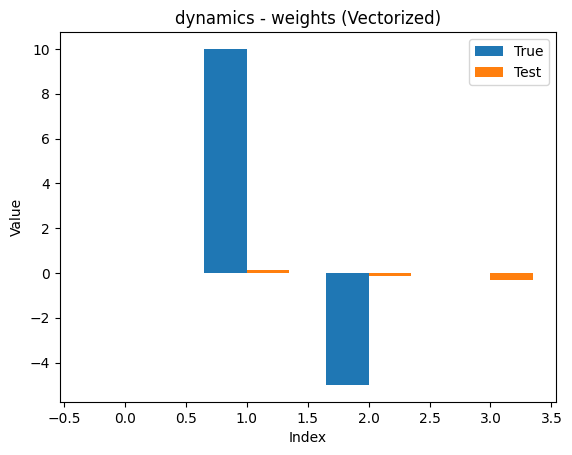

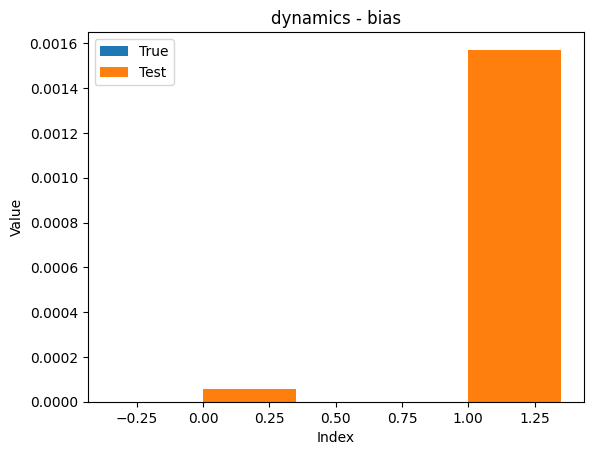

/tmp/ipykernel_34441/951752220.py:23: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(matrix, cmap='viridis', aspect='auto')


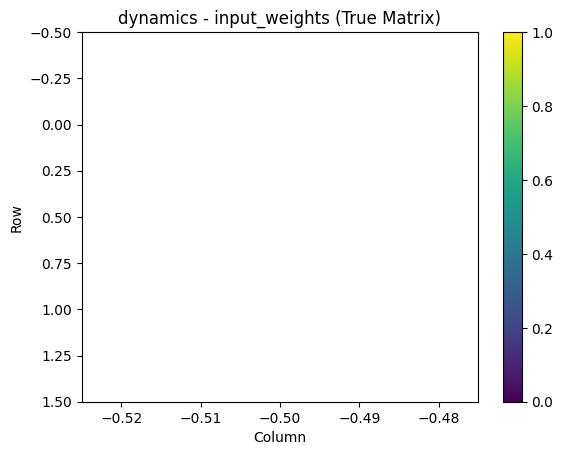

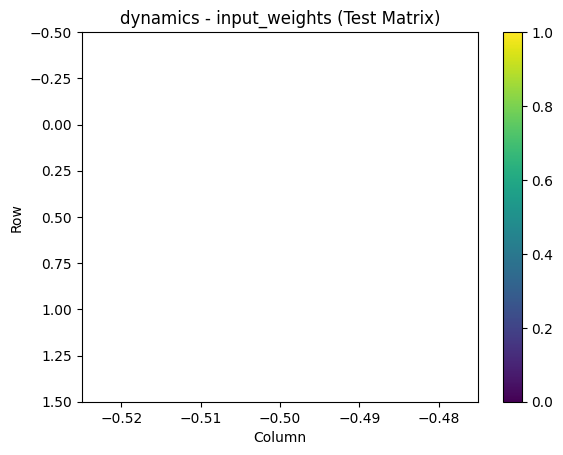

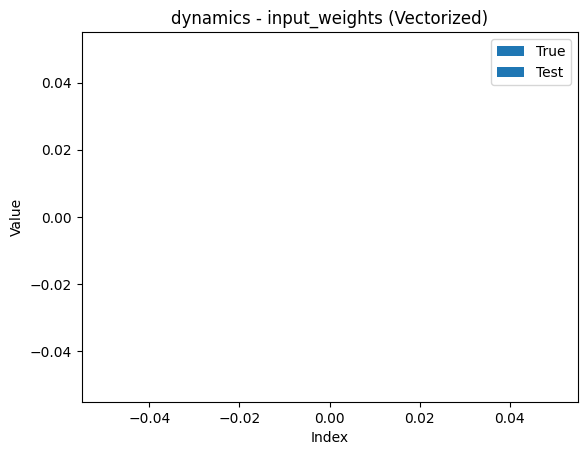

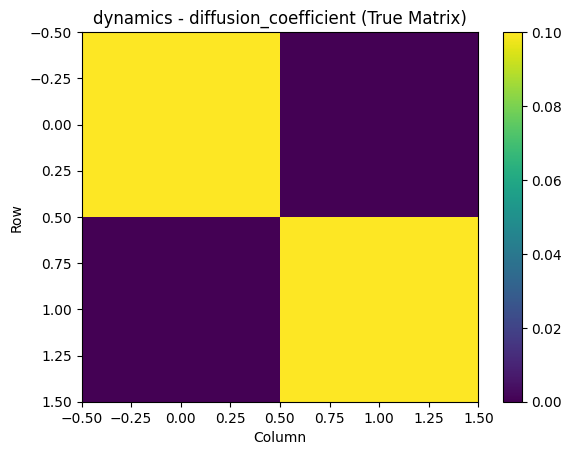

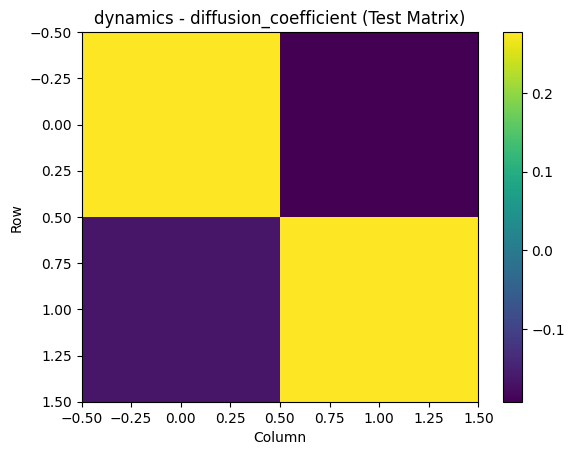

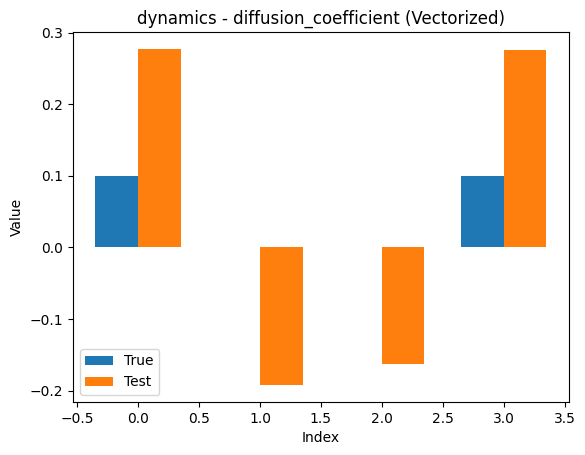

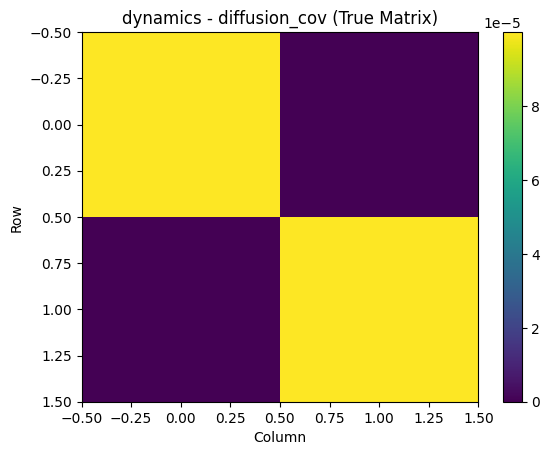

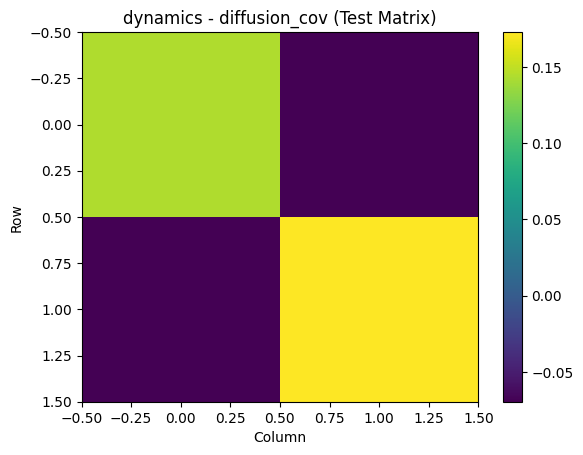

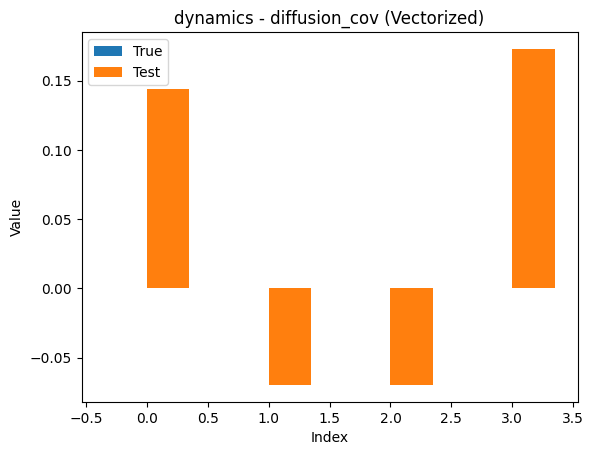

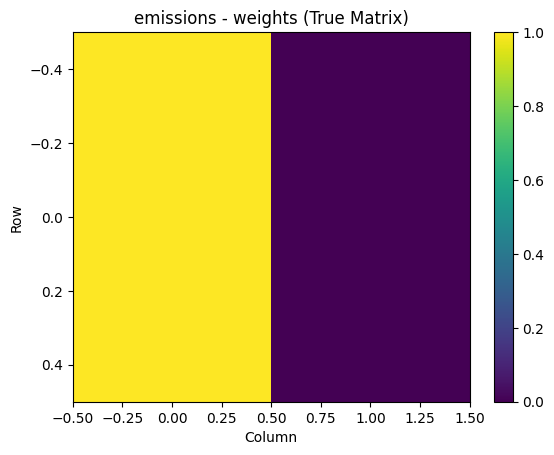

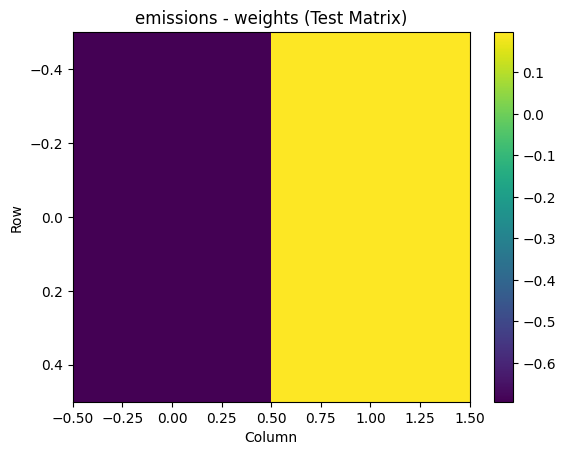

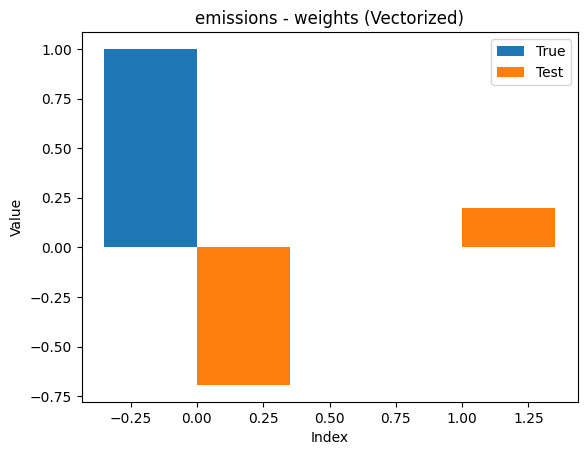

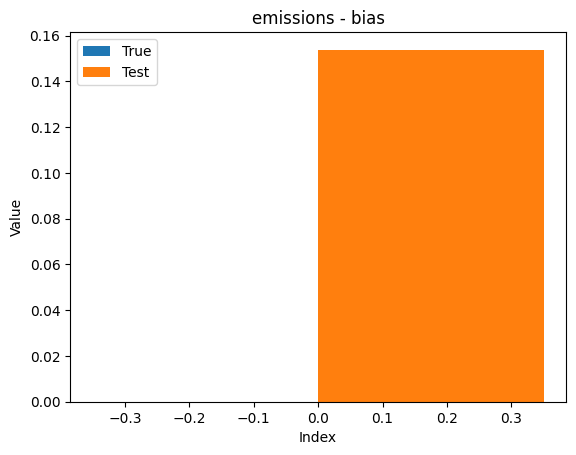

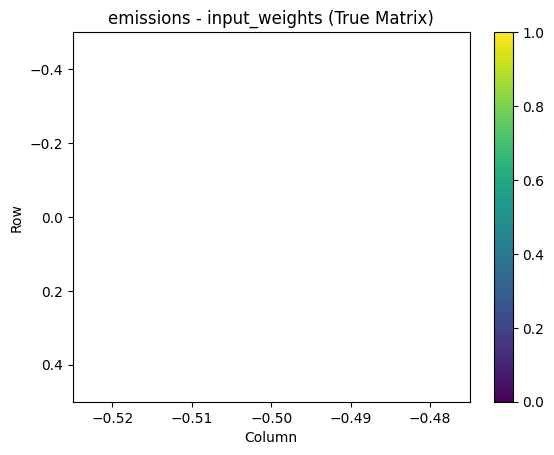

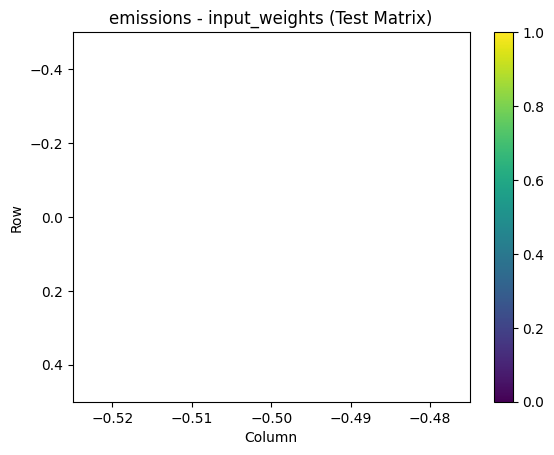

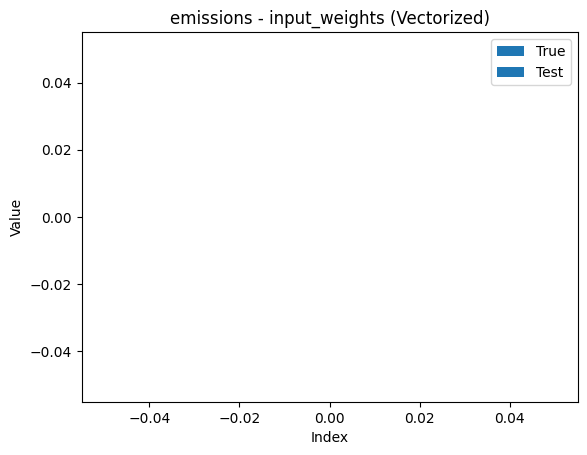

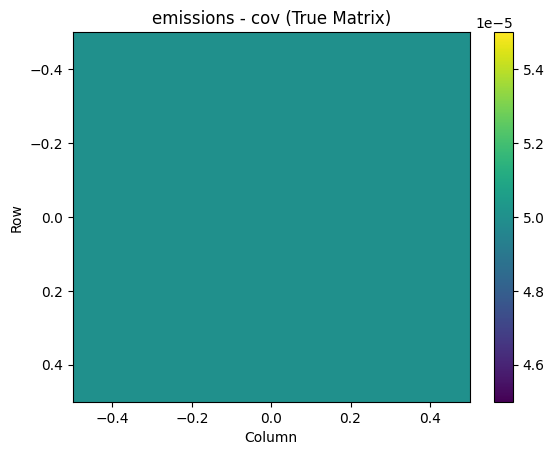

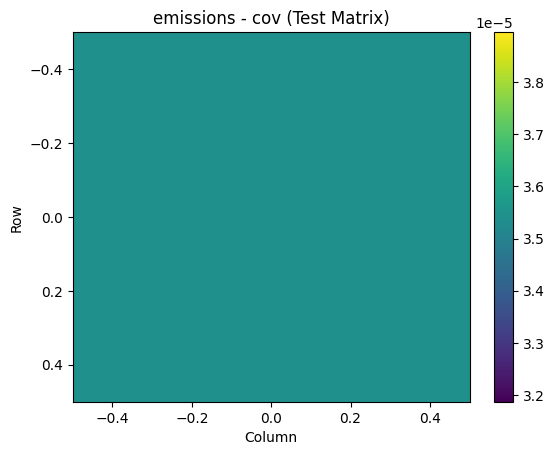

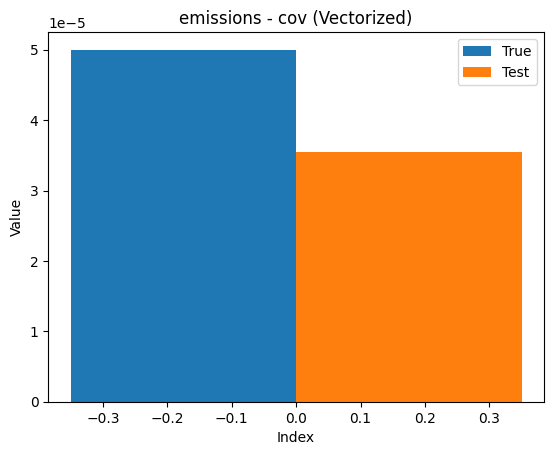

In [11]:
plot_learning_curve(
    marginal_lls, true_model, true_params, test_model, test_params, emissions, t_emissions, filter_hyperparams)
plot_predictions(true_model, true_params, test_model, test_params, emissions, t_emissions)
compare_parameters(true_params, test_params)

In [12]:
# Define new model, with different key seeding
test_model = MySSM(state_dim, emission_dim)
key = jr.PRNGKey(42)
test_params, param_props = test_model.initialize(key)

# Fit model with default filtering
num_epochs = 1000
test_params, neg_marginal_lls = test_model.fit_sgd(
    test_params,
    param_props,
    emissions,
    t_emissions,
    optimizer=optimizer,
    num_epochs=num_epochs
)
marginal_lls = -neg_marginal_lls * emissions.size

In [15]:
test_params

ParamsCDLGSSM(initial=ParamsLGSSMInitial(mean=Array([-0.00076043, -0.3918184 ], dtype=float32), cov=Array([[0.00037032, 0.00179945],
       [0.00179945, 0.00897145]], dtype=float32)), dynamics=ParamsCDLGSSMDynamics(weights=Array([[-0.6347235,  0.1716053],
       [ 0.4191336, -0.1782454]], dtype=float32), bias=Array([ 0.02515054, -0.10052635], dtype=float32), input_weights=Array([], dtype=float32), diffusion_coefficient=Array([[0.09560422, 0.08878586],
       [0.48572665, 0.45231572]], dtype=float32), diffusion_cov=Array([[0.10540938, 0.1009152 ],
       [0.1009152 , 0.19150387]], dtype=float32)), emissions=ParamsLGSSMEmissions(weights=Array([[-1.5972643 ,  0.33868888]], dtype=float32), bias=Array([-0.00871839], dtype=float32), input_weights=Array([], dtype=float32), cov=Array([[0.0002192]], dtype=float32)))

Running KF smoother type = cd_smoother_1
Running KF smoother type 1


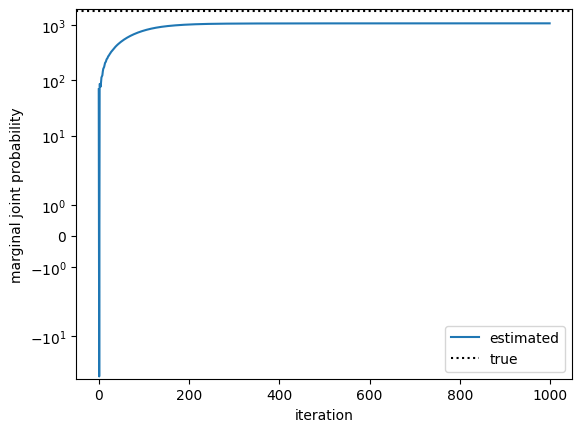

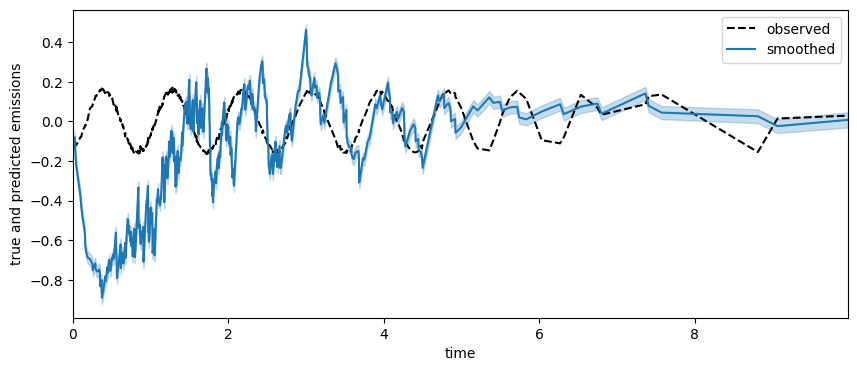

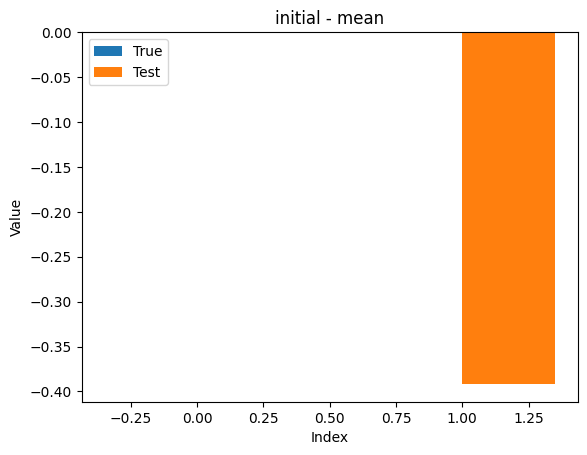

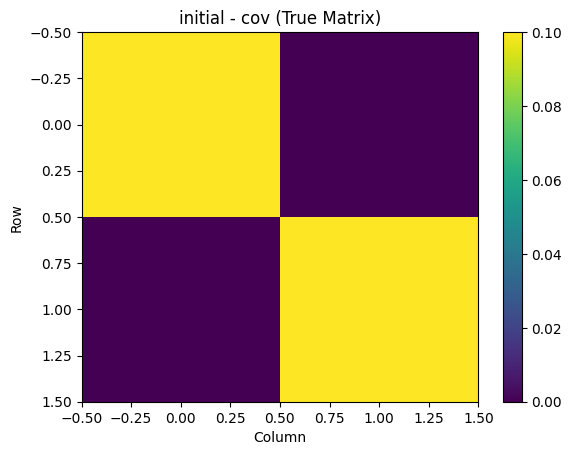

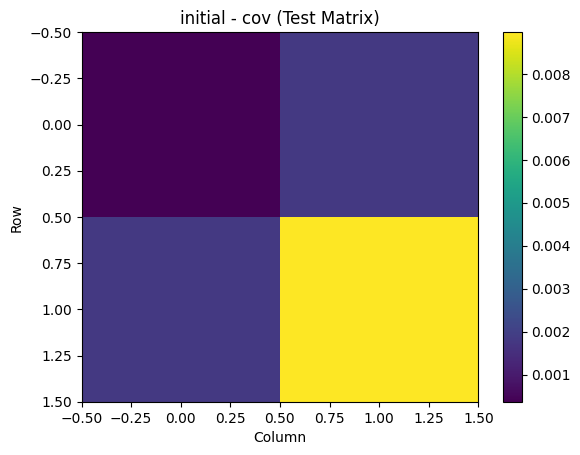

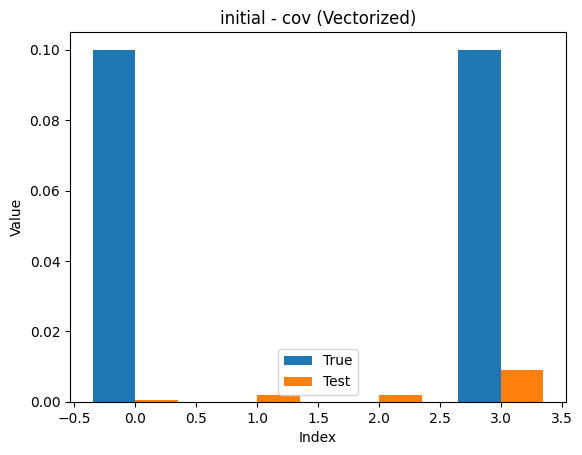

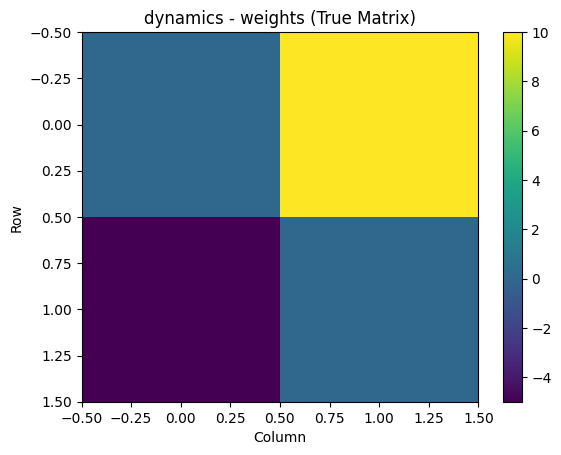

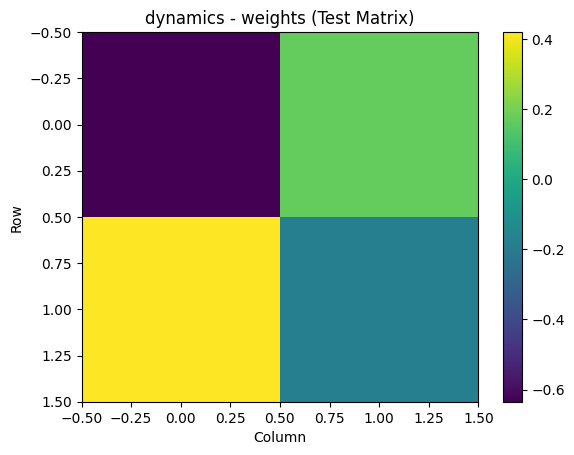

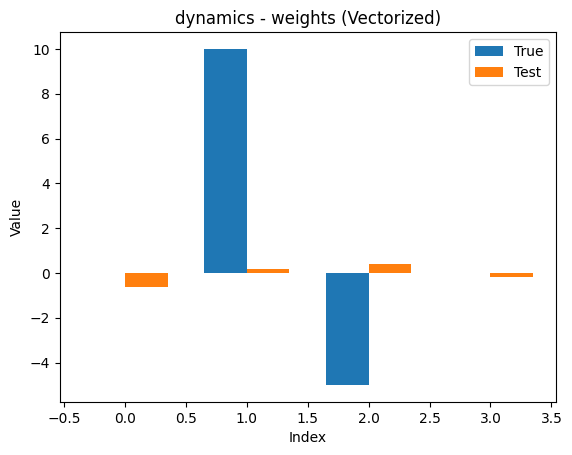

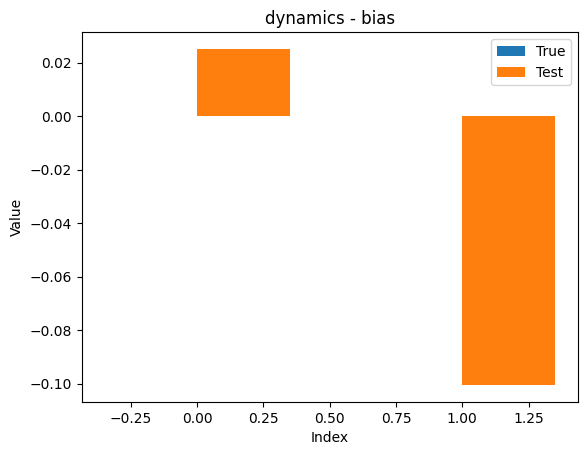

/tmp/ipykernel_34441/951752220.py:23: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(matrix, cmap='viridis', aspect='auto')


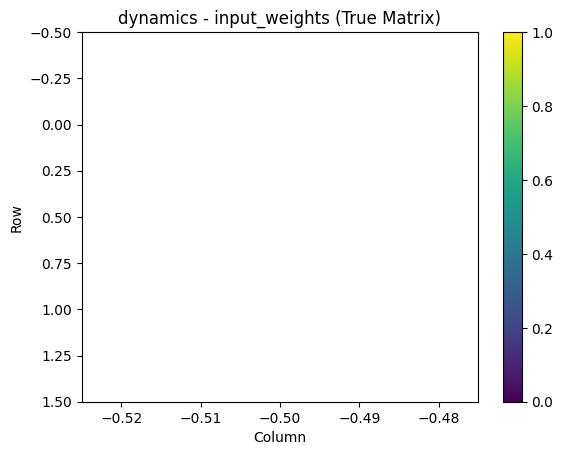

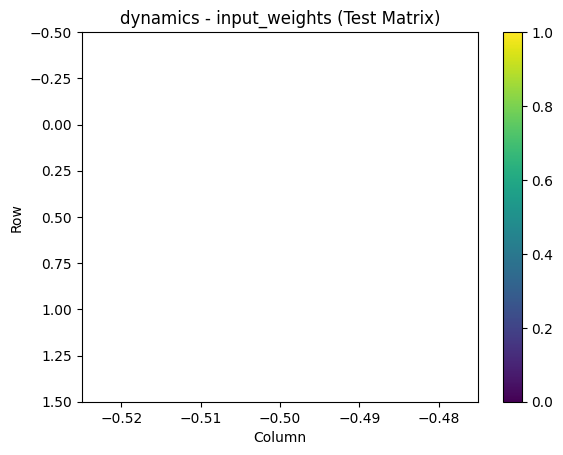

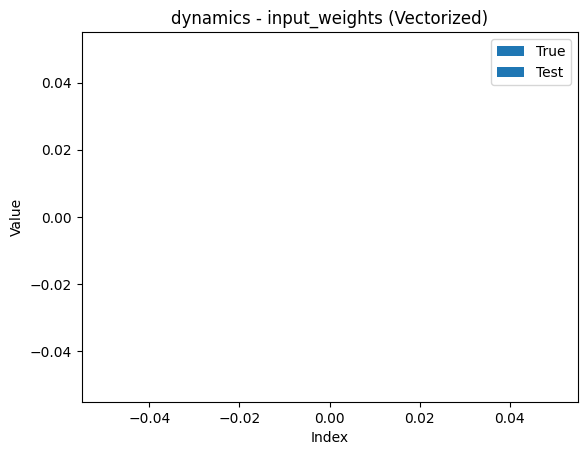

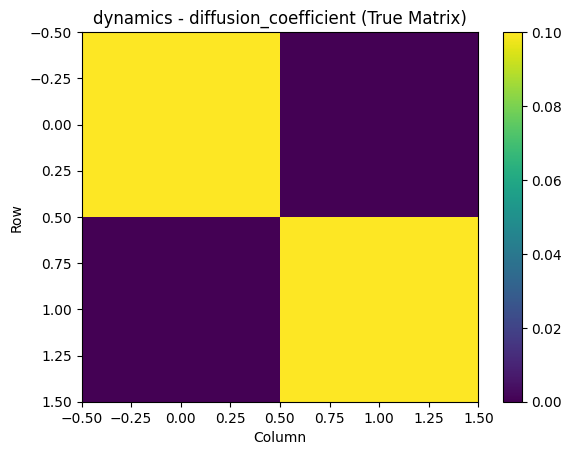

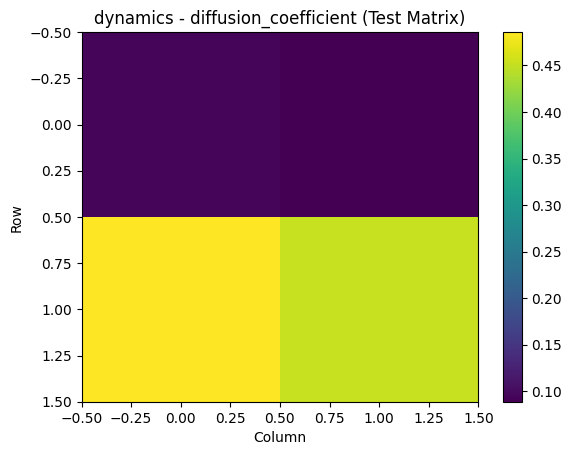

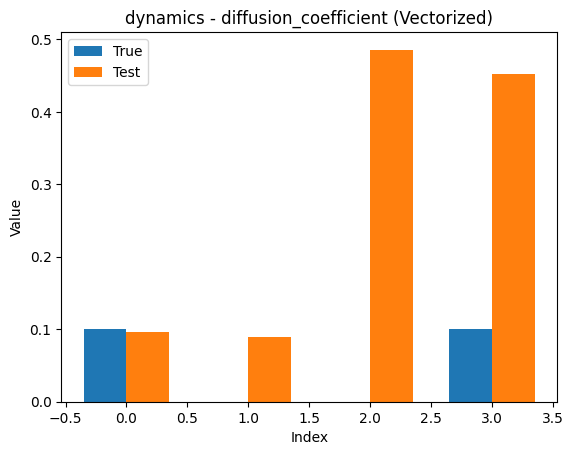

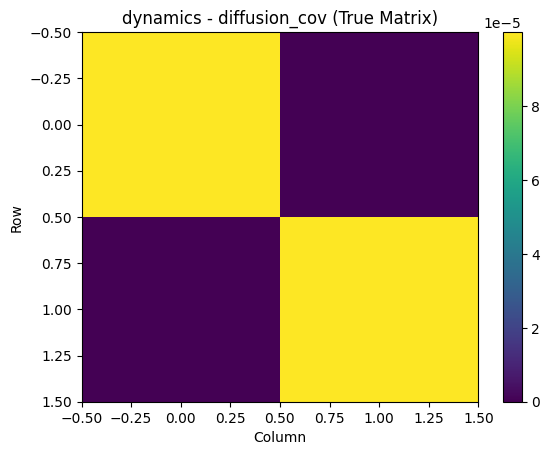

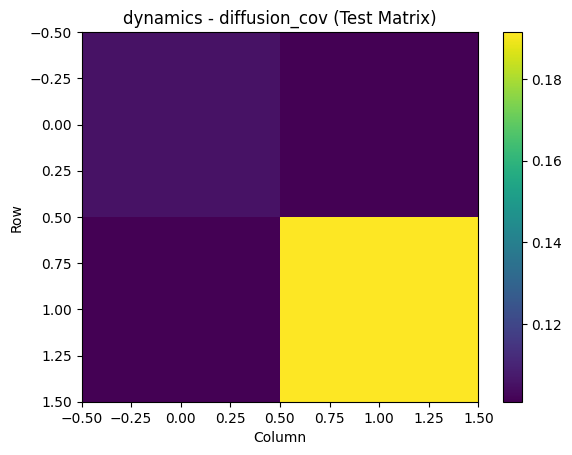

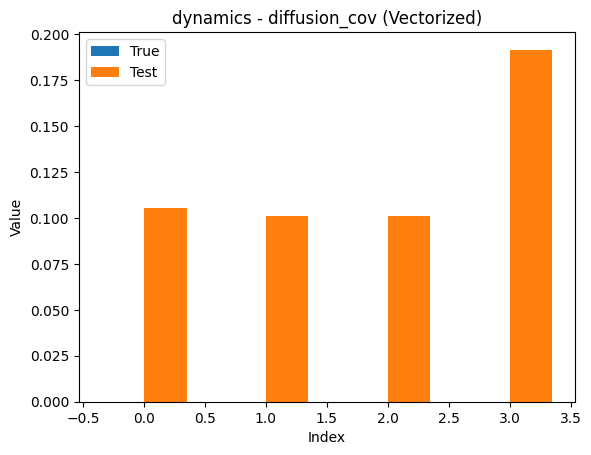

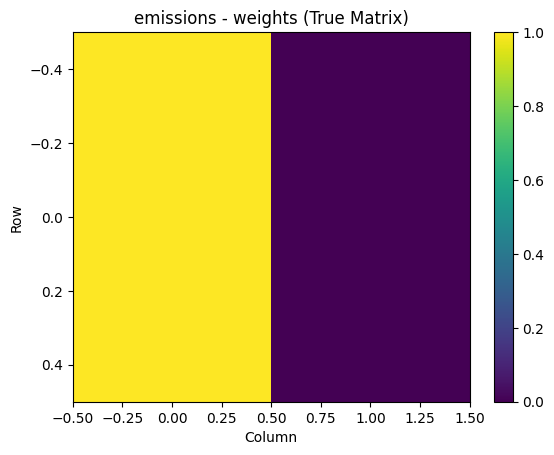

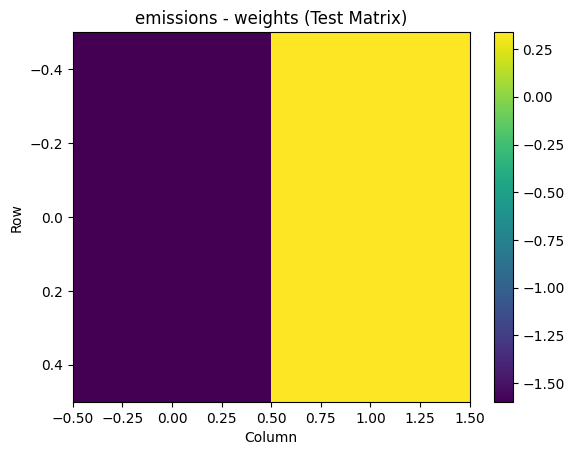

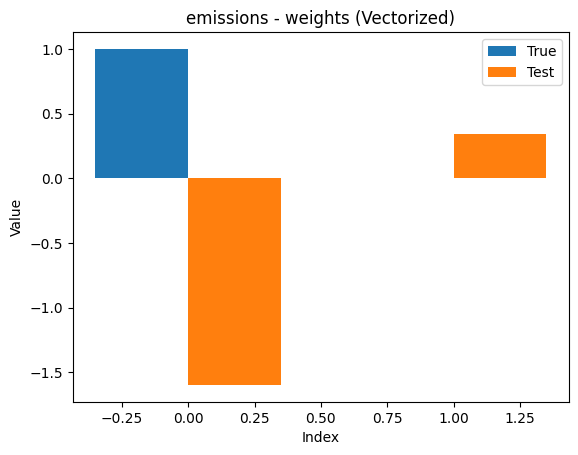

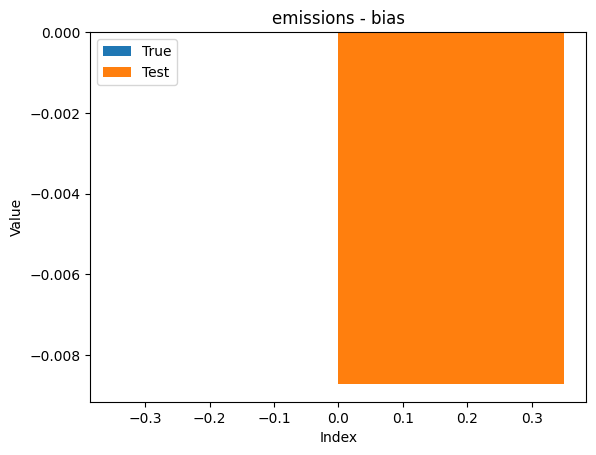

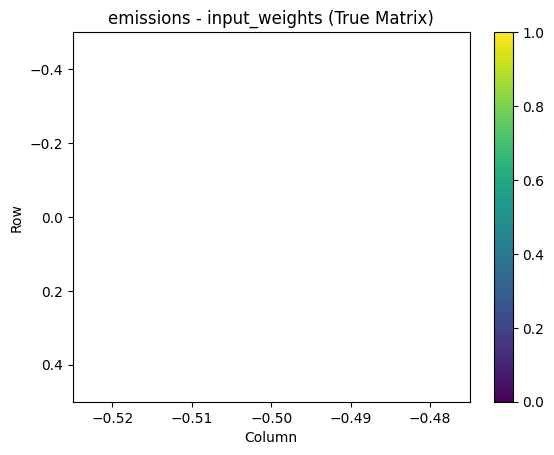

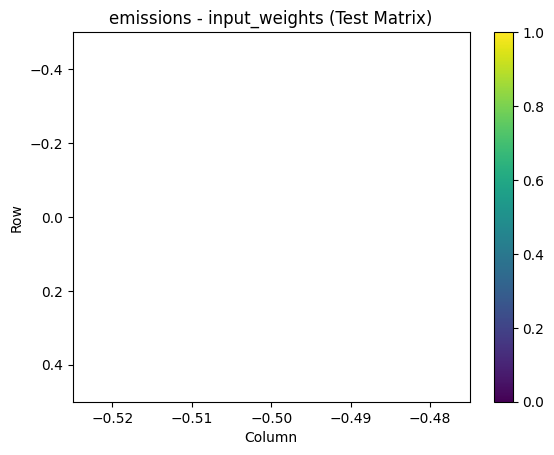

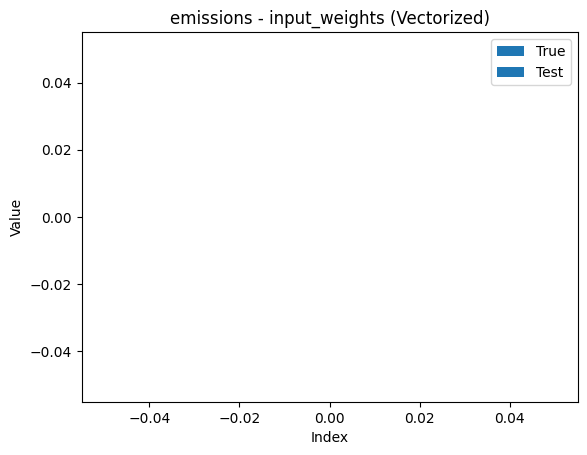

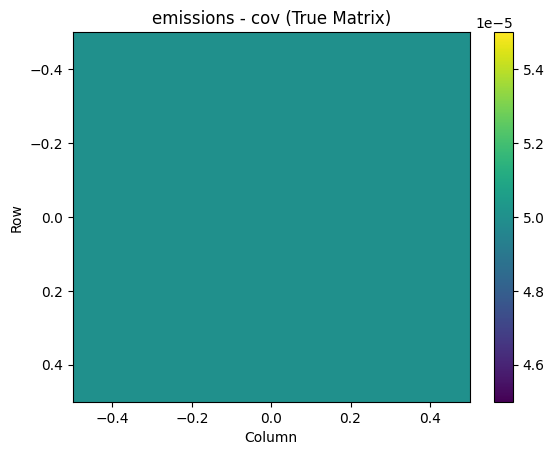

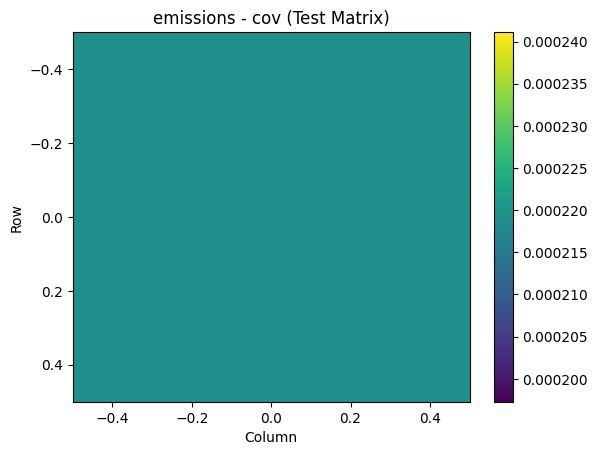

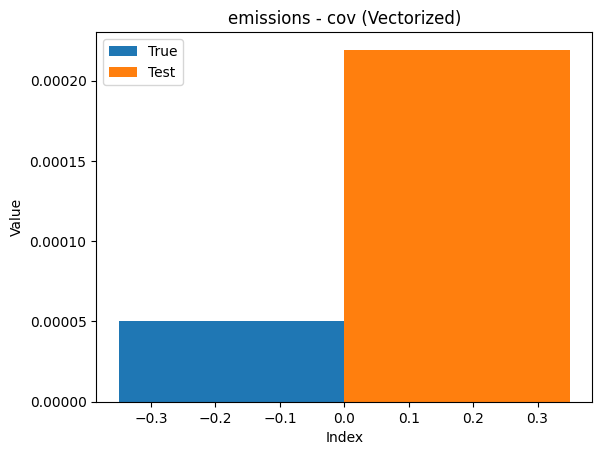

In [14]:
plot_learning_curve(
    marginal_lls,
    true_model,
    true_params,
    test_model,
    test_params,
    emissions,
    t_emissions,
    None
)
plot_predictions(
    true_model,
    true_params,
    test_model,
    test_params,
    emissions,
    t_emissions
)
compare_parameters(
    true_params,
    test_params
)